<a href="https://colab.research.google.com/github/Madhu-271005/Launched-Global-Projects/blob/main/AI_Study_Pal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Setup & Install Required Libraries
This cell installs all the Python libraries needed for the project:
- `nltk` → Natural Language Processing
- `flask` → Web app
- `scikit-learn` → Machine Learning models
- `keras` & `tensorflow` → Deep Learning


In [ ]:
;!pip install nltk flask scikit-learn keras tensorflow

/bin/bash: -c: line 1: syntax error near unexpected token `"install nltk flask scikit-learn keras tensorflow"'
/bin/bash: -c: line 1: `pip("install nltk flask scikit-learn keras tensorflow")'


#  Import Libraries
Now we import all the libraries we just installed so we can use them in the project.


In [ ]:
import matplotlib.pyplot as plt
import nltk
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# download stopwords and tokenizer data
nltk.download('punkt')
nltk.download('stopwords')

/bin/bash: -c: line 1: syntax error near unexpected token `"install nltk flask scikit-learn keras tensorflowimport pandas as pd"'
/bin/bash: -c: line 1: `pip("install nltk flask scikit-learn keras tensorflowimport pandas as pd")'


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

- **Purpose:** Load the Question-Answer dataset.  
- **Input:** `/content/S08_question_answer_pairs.txt` (tab-separated file)  
- **Output:** Pandas DataFrame showing the first few rows  

> ⚠️ Warning: Make sure the file path is correct.


In [ ]:
import pandas as pd

df = pd.read_csv("/content/S08_question_answer_pairs.txt", sep="\t")
df.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4


## Clean Dataset

- **Purpose:** Remove duplicate rows and normalize answers.  
- **Steps:**
  1. Remove duplicates
  2. Convert answers to lowercase
  3. Remove trailing periods  

- **Input:** `df` from previous cell  
- **Output:** Cleaned DataFrame with normalized answers


## Clean & Normalize Answers

- **Purpose:** Prepare the dataset for quiz generation.  
- **Steps:**
  1. Remove duplicate rows from the dataset.  
  2. Convert all answers to lowercase for consistency.  
  3. Remove trailing periods from answers.  

- **Input:** DataFrame `df` from previous cell.  
- **Output:** Cleaned DataFrame ready for use in quizzes.


In [ ]:
df = df.drop_duplicates()
df['Answer'] = df['Answer'].str.lower().str.strip('.')


In [ ]:
sample = df.sample(5)
for i, row in sample.iterrows():
    print("Q:", row["Question"])
    print("Answer:", row["Answer"])
    print("---")

Q: Where was Grover Cleveland married?
Answer: in the white house
---
Q: What is surplus killing?
Answer: the killing of several prey animals too numerous to eat at one sitting
---
Q: What is The Remarkable Millard Fillmore?
Answer: in 2007, george pendle wrote the remarkable millard fillmore, a fake biography based on real events that happened in fillmore's life
---
Q: What did Coolidge address in 1924?
Answer: nan
---
Q: What happened in the election of 1816?
Answer: monroe was elected president
---


In [ ]:
print(df.columns.tolist())


['ArticleTitle', 'Question', 'Answer', 'DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile']


In [ ]:
import re, pandas as pd

# Replace literal 'NULL' strings with empty
df = df.replace({'NULL': '', 'nan': ''})

# normalize answers
def normalize_answer(a):
    if pd.isna(a):
        return ''   # fixed here (removed /)
    s = str(a).strip()
    s = re.sub(r'\.+$', '', s)        # remove trailing dots
    s = re.sub(r'\s+', ' ', s)        # multi-space -> one
    return s.lower()

df['Answer_norm'] = df['Answer'].apply(normalize_answer)

# drop rows with empty answers (if any)
before = len(df)
df = df[df['Answer_norm'] != ''].copy()
print('Rows before:', before, '| after removing empty answers:', len(df))


Rows before: 1573 | after removing empty answers: 1362


In [ ]:
before = len(df)
df = df.drop_duplicates(subset=['ArticleTitle','Question','Answer_norm'])
after = len(df)
print('Dropped duplicates:', before - after, '  Remaining rows:', after)


Dropped duplicates: 216   Remaining rows: 1146


In [ ]:
valid = {'easy','medium','hard'}
# if exact match else NaN
df['DiffQ_clean'] = df['DifficultyFromQuestioner'].where(df['DifficultyFromQuestioner'].isin(valid))
print(df['DiffQ_clean'].value_counts(dropna=False))


DiffQ_clean
NaN       319
hard      300
medium    290
easy      237
Name: count, dtype: int64


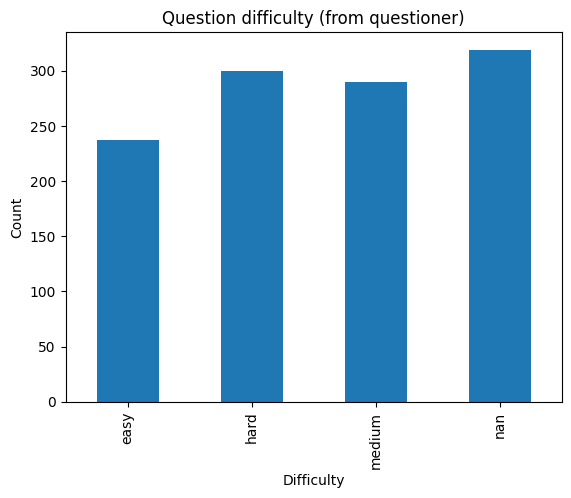

In [ ]:
import matplotlib.pyplot as plt
counts = df['DiffQ_clean'].value_counts(dropna=False).sort_index()
counts.plot(kind='bar')
plt.title('Question difficulty (from questioner)')
plt.xlabel('Difficulty'); plt.ylabel('Count')
plt.show()


In [ ]:
import random
rnd = random.Random(42)

# pool of possible answers (normalized)
answer_pool = df['Answer_norm'].dropna().unique().tolist()

def make_options(correct, pool, k=3):
    # choose k distractors (not equal to correct)
    candidates = [p for p in pool if p != correct and 1 <= len(p) <= 40]
    if len(candidates) >= k:
        distractors = rnd.sample(candidates, k)
    else:
        distractors = candidates
    opts = [correct] + distractors
    rnd.shuffle(opts)
    # fill to 4 options if needed
    while len(opts) < 4:
        opts.append("None of the above")
    return opts[:4]

def build_quiz(df_in, n=10):
    base = df_in.copy()
    # prefer rows with known difficulty, else use all
    subset = base[base['DiffQ_clean'].isin(['easy','medium','hard'])]
    if subset.empty:
        subset = base
    sample = subset.sample(min(n, len(subset)), random_state=1)
    rows = []
    for _, r in sample.iterrows():
        q = str(r['Question']).strip()
        ans = str(r['Answer_norm'])
        if ans in ('yes','no'):
            options = ['yes','no','maybe','not sure']
        else:
            options = make_options(ans, answer_pool, k=3)
        rows.append({
            'question': q,
            'options': options,
            'correct': ans,
            'difficulty': r.get('DiffQ_clean',''),
            'article': r.get('ArticleTitle','')
        })
    return pd.DataFrame(rows)

# Generate and show 10 sample MCQs
quiz_df = build_quiz(df, n=10)
quiz_df.head(10)


,question,options,correct,difficulty,article
0,What is the first word on the page?,"[penguins, john alexander mcclernand, james, g...",james,easy,James_Monroe
1,What method of locomotion do Kangaroos Use?,"[the town of plymouth notch, no, it is not, mo...",hopping,medium,kangaroo
2,What caused Wilson to ask Congress to declare ...,"[massachus08_setts, 1846, german began unrestr...",german began unrestricted submarine warfare,hard,Woodrow_Wilson
3,Are penguins birds?,"[yes, no, maybe, not sure]",yes,easy,penguin
4,How much time to penguins spend on land?,"[the new kingdom (c.1550&#8722;1070 bc), i don...",half of their life,hard,penguin
5,When did the Gettysburg address argue that Ame...,"[nelson rockefeller, roadkill deaths, papillae...",1776,hard,Abraham_Lincoln
6,How much of the population is of white Europea...,"[bob dole, approximately 88% of its population...",approximately 88% of its population are of pre...,medium,Uruguay
7,"Who was the first gymnast to score a perfect ""...","[nadia comăneci, july 4 1872, massachus08_sett...",nadia comăneci,medium,Romania
8,How heavy was the largest polar bear on record?,"[a female turtle, he allegedly weighed 1002 kg...",he allegedly weighed 1002 kg,medium,polar_bear
9,How much does a leopard weigh?,"[(because of ambiguity) - 28-90kg, staunton, v...",(because of ambiguity) - 28-90kg,medium,leopard


## Build Quiz from Dataset

- **Purpose:** Generate multiple-choice questions (MCQs) from cleaned dataset.  
- **Steps:**
  1. Normalize answers from dataset.  
  2. Use `make_options()` to create distractors for each correct answer.  
  3. Sample `n` questions (default 10) from dataset, considering difficulty if available.  
  4. Return a DataFrame with columns:
     - `question` → question text  
     - `options` → list of 4 answer choices  
     - `correct` → correct answer  
     - `difficulty` → easy/medium/hard (if available)  
     - `article` → source article (if available)  

- **Input:** Cleaned dataset `df`  
- **Output:** DataFrame of MCQs ready for the study app


In [ ]:
for i, r in quiz_df.iterrows():
    print(f"Q{i+1}. {r['question']}")
    for j,opt in enumerate(r['options']):
        print(f"   {chr(65+j)}. {opt}")
    print("Answer:", r['correct'])
    print()
    if i>=4: break  # show only first 5


Q1. What is the first word on the page?
   A. penguins
   B. john alexander mcclernand
   C. james
   D. grace anna goodhue
Answer: james

Q2. What method of locomotion do Kangaroos Use?
   A. the town of plymouth notch
   B. no, it is not
   C. more than 2.78 million people
   D. hopping
Answer: hopping

Q3. What caused Wilson to ask Congress to declare war on the Central Powers?
   A. massachus08_setts
   B. 1846
   C. german began unrestricted submarine warfare
   D. 23 years
Answer: german began unrestricted submarine warfare

Q4. Are penguins birds?
   A. yes
   B. no
   C. maybe
   D. not sure
Answer: yes

Q5. How much time to penguins spend on land?
   A. the new kingdom (c.1550&#8722;1070 bc)
   B. i don't know (semantic ambiguity)
   C. half of their life
   D. hungarians
Answer: half of their life



## Save Quiz and Dataset

- **Purpose:** Save generated quiz and cleaned QA dataset for submission.  
- **Files:**
  - `quiz_sample.csv` → 10 sample MCQs generated for the app  
  - `qa_clean.csv` → Cleaned question-answer dataset used for quiz generation  
- **Colab Download:** Enables downloading the files locally.


In [ ]:
quiz_df.to_csv('quiz_sample.csv', index=False)
df.to_csv('qa_clean.csv', index=False)
print("Saved quiz_sample.csv and qa_clean.csv")
# To download in Colab:
from google.colab import file
files.download('quiz_sample.csv')   # will prompt download


Saved quiz_sample.csv and qa_clean.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Generate Study Plan

- **Purpose:** Create a study plan based on a topic and available study hours.  
- **Logic:**
  - Filter questions by topic keyword (`ArticleTitle`)  
  - Calculate number of sessions based on `hours` and `session_minutes`  
  - Assign ~3 questions per session  
- **Output:** DataFrame with sessions, duration, and assigned questions.


In [ ]:
def make_study_plan(df_in, topic_keyword, hours, session_minutes=30):
    mask = df_in['ArticleTitle'].str.contains(topic_keyword, case=False, na=False)
    subset = df_in[mask].copy()
    if subset.empty:
        subset = df_in.sample(min(30,len(df_in)), random_state=0)
    total_minutes = int(hours*60)
    sessions = max(1, total_minutes // session_minutes)
    needed = min(sessions*3, len(subset))
    chosen = subset.sample(needed, random_state=1)
    rows=[]
    idx=0
    for s in range(1, sessions+1):
        block = chosen.iloc[idx:idx+3]
        rows.append({
            'session': s,
            'duration_minutes': session_minutes,
            'questions': block['Question'].tolist()
        })
        idx += 3
        if idx >= len(chosen): break
    return pd.DataFrame(rows)

# Example: topic "Abraham", for 2 hours
plan = make_study_plan(df, topic_keyword='Abraham', hours=2)
plan


,session,duration_minutes,questions
0,1,30,"[How long was Lincoln's legal Career?, How man..."
1,2,30,"[Did lincoln have 18 months of schooling?, Do ..."
2,3,30,[Why did Lincoln issue the Emancipation Procla...
3,4,30,"[How old was Lincoln in 1816?, Did Lincoln win..."


In [ ]:
import glob
paths = glob.glob('/content/*question_answer_pairs*.txt')  # or /mnt/data/
frames = []
for p in paths:
    tmp = pd.read_csv(p, sep="\t", encoding='utf-8', engine='python')
    frames.append(tmp)
big = pd.concat(frames, ignore_index=True)
print("Combined rows:", len(big))


Combined rows: 1715


In [ ]:
import re, pandas as pd

# Replace literal 'NULL' or 'nan' with empty
df = df.replace({'NULL': '', 'nan': ''})

# Normalize answers
def normalize_answer(a):
    if pd.isna(a): return ''
    s = str(a).strip()
    s = re.sub(r'\.+$', '', s)        # remove trailing dots
    s = re.sub(r'\s+', ' ', s)        # collapse spaces
    return s.lower()

df['Answer_norm'] = df['Answer'].apply(normalize_answer)

# Drop rows with empty answers
before = len(df)
df = df[df['Answer_norm'] != ''].copy()
print('Rows before:', before, '| after removing empty answers:', len(df))


Rows before: 1146 | after removing empty answers: 1146


In [ ]:
before = len(df)
df = df.drop_duplicates(subset=['ArticleTitle','Question','Answer_norm'])
after = len(df)
print('Dropped duplicates:', before - after, '  Remaining rows:', after)


Dropped duplicates: 0   Remaining rows: 1146


In [ ]:
valid = {'easy','medium','hard'}
df['DiffQ_clean'] = df['DifficultyFromQuestioner'].where(df['DifficultyFromQuestioner'].isin(valid))
print(df['DiffQ_clean'].value_counts(dropna=False))


DiffQ_clean
NaN       319
hard      300
medium    290
easy      237
Name: count, dtype: int64


## Question Difficulty Analysis

- **Purpose:** Visualize the number of questions per difficulty level (`easy`, `medium`, `hard`).  
- **Logic:** Count occurrences of `DiffQ_clean` column and plot a bar chart.  
- **Output:** Shows both **numeric counts** and **bar plot**.


DiffQ_clean
easy      237
hard      300
medium    290
NaN       319
Name: count, dtype: int64


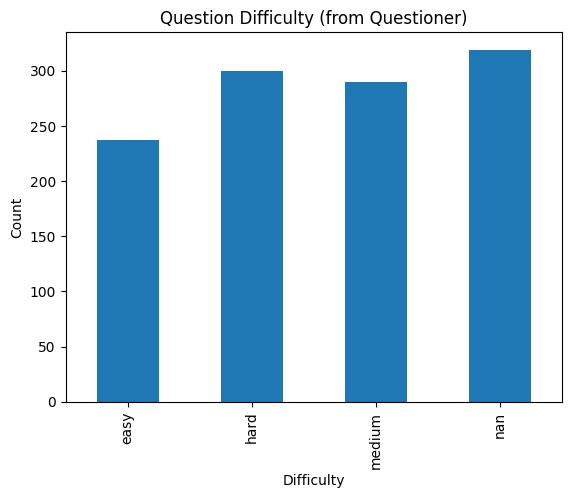

In [ ]:
import matplotlib.pyplot as plt

counts = df['DiffQ_clean'].value_counts(dropna=False).sort_index()
print(counts)   # print the numbers also

plt.figure()
counts.plot(kind='bar')
plt.title('Question Difficulty (from Questioner)')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.show()


##  Predicting Question Difficulty with ML

- **Purpose:** Build a model to predict difficulty (`easy`, `medium`, `hard`) from the question text.  
- **Steps:**
  1. Filter dataset to only rows with valid difficulty labels.  
  2. Convert questions to numerical features using **TF-IDF**.  
  3. Split data into training and test sets (80/20).  
  4. Train a **Logistic Regression** classifier.  
  5. Evaluate using **classification report** (precision, recall, f1-score).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Only rows with valid difficulty
ml_df = df[df['DiffQ_clean'].notna()].copy()

X = ml_df['Question']
y = ml_df['DiffQ_clean']

# Convert text to numerical features
vec = TfidfVectorizer(max_features=3000, stop_words='english')
X_vec = vec.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train model
clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        easy       0.61      0.44      0.51        45
        hard       0.55      0.73      0.63        59
      medium       0.65      0.58      0.62        62

    accuracy                           0.60       166
   macro avg       0.60      0.58      0.59       166
weighted avg       0.60      0.60      0.59       166



In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Text Summarization (NLP)

- **Purpose:** Summarize long study material into a few key sentences.  
- **Method:**
  - Tokenize text into words and sentences using NLTK.  
  - Build a frequency table of important words.  
  - Score sentences based on word frequencies.  
  - Select top `N` sentences as summary.  
- **Example:** Summarizing a short text about Abraham Lincoln.


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import heapq

nltk.download('punkt')
nltk.download('stopwords')

def summarize_text(text, num_sentences=2):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text.lower())

    freq = {}
    for w in words:
        if w not in stop_words and w.isalpha():
            freq[w] = freq.get(w,0)+1

    # Score sentences
    sentences = sent_tokenize(text)
    sent_scores = {}
    for sent in sentences:
        for w in word_tokenize(sent.lower()):
            if w in freq:
                sent_scores[sent] = sent_scores.get(sent,0)+freq[w]

    # Top sentences
    summary = heapq.nlargest(num_sentences, sent_scores, key=sent_scores.get)
    return " ".join(summary)

sample_text = """Abraham Lincoln was the 16th President of the United States.
He led the nation through the American Civil War.
He preserved the Union and abolished slavery.
He gave the famous Gettysburg Address."""

print("Summary:", summarize_text(sample_text))


Summary: Abraham Lincoln was the 16th President of the United States. He led the nation through the American Civil War.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##  Student Feedback System

- **Purpose:** Provide encouraging feedback based on quiz performance.  
- **Logic:**  
  - `>= 80%` → 🌟 Excellent work!  
  - `>= 50%` → 👍 Good job, but revise weak topics.  
  - `< 50%` → 💡 Don’t give up! Practice more and you’ll improve.  
- **Example:** For 8/10 correct → "🌟 Excellent work! Keep it up."


In [ ]:
def feedback(score, total):
    percent = (score/total)*100
    if percent >= 80:
        return "🌟 Excellent work! Keep it up."
    elif percent >= 50:
        return "👍 Good job, but revise weak topics."
    else:
        return "💡 Don’t give up! Practice more and you’ll improve."

print(feedback(8,10))   # Example: 8/10 correct


🌟 Excellent work! Keep it up.


##  Keyword Extraction

- **Purpose:** Extract the most important words from a passage or answer.  
- **Method:** Uses `CountVectorizer` (Bag-of-Words) to count word frequency.  
- **Example Input:**  
  "Machine learning uses algorithms and data to learn patterns. AI can make predictions using models."  
- **Output:**  
  `['machine', 'learning', 'uses', 'algorithms', 'data']`


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_keywords(text, top_n=5):
    vec = CountVectorizer(stop_words='english').fit([text])
    bag = vec.transform([text])
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return [w for w,f in words_freq[:top_n]]

sample_text = "Machine learning uses algorithms and data to learn patterns. AI can make predictions using models."
print("Keywords:", get_keywords(sample_text))


Keywords: ['machine', 'learning', 'uses', 'algorithms', 'data']


##  Resource Recommendation (Optional)

- **Purpose:** Suggests useful study resources for a given subject.  
- **Method:** Simple `if-elif` rule-based system that matches keywords (e.g., Math, AI, History).  
- **Example:**  
  Input → "AI"  
  Output → ["Andrew Ng ML course", "https://www.coursera.org/learn/machine-learning"]


In [ ]:
def suggest_resources(subject):
    subject = subject.lower()
    if "math" in subject:
        return ["Khan Academy - Math", "https://www.khanacademy.org/math"]
    elif "ai" in subject or "ml" in subject:
        return ["Andrew Ng ML course", "https://www.coursera.org/learn/machine-learning"]
    elif "history" in subject:
        return ["History.com", "https://www.history.com/"]
    else:
        return ["Wikipedia", "https://en.wikipedia.org"]

print(suggest_resources("AI"))


['Andrew Ng ML course', 'https://www.coursera.org/learn/machine-learning']


### Step 1: Add Ngrok Auth Token  
This command saves the ngrok authentication token in Colab.  
It allows us to create secure tunnels to expose our Flask app publicly.  
We need to run this only once.


In [ ]:
!ngrok config add-authtoken 333wfZBhE0ggk4fX0U2tW8yDjYY_2hXxN6MP3TSzpTSZpNisX

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


### Step 2: Kill Old Ngrok Tunnels  
This step ensures no previous ngrok tunnels are running.  
It helps avoid errors like **ERR_NGROK_3200** when restarting the server.


In [ ]:
from pyngrok import ngrok
ngrok.kill()

### Step 3: Start Ngrok Tunnel and Run Flask App  
Here we connect Flask (running on port 5000) with ngrok to get a public URL.  
The public URL can be shared for testing the project online.


In [ ]:
app.run(port=5000, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


### Step 4: Run Flask App with Ngrok Tunnel  
In this step:  
- We import ngrok and configure the **auth token**.  
- Start a tunnel on port **5000** (where Flask runs).  
- Print the **public URL** generated by ngrok.  
- Finally, run the Flask app so it is accessible online using the public URL.  


In [ ]:
from pyngrok import ngrok, conf

# set token
conf.get_default().auth_token = "333wfZBhE0ggk4fX0U2tW8yDjYY_2hXxN6MP3TSzpTSZpNisX"

# start tunnel
public_url = ngrok.connect(5000)
print("Public URL:", public_url)

# run app
app.run(port=5000, debug=False)


Public URL: NgrokTunnel: "https://96c880c456b0.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [22/Sep/2025 16:46:33] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Sep/2025 16:46:34] "GET /favicon.ico HTTP/1.1" 404 -
